# Exploração de Dados

> Neste notebook iremos visualizar a distribuição e a relação de cada uma das informações que temos do dataset para identificar quais seriam as colunas mais interessantes para utilizar na análise

In [1]:
# Importando bibliotecas necessárias
import snowflake.connector
import pandas as pd
import numpy as np
import orchest
import os
from dadosfera import *
import seaborn as sns
import matplotlib.pyplot as plt

### 1. Recuperar dados do passo anterior

In [5]:
# Recuperando dados do passo anterior
data = dadosfera_utils.get_inputs() 
df = data['df']

print(f'Colunas atuais: {df.columns}')
df.head()

Colunas atuais: Index(['__SDC_ROW', '__SDC_SHEET_ID', '__SDC_SPREADSHEET_ID', 'away_score',
       'away_team', 'city', 'country', 'date', 'home_score', 'home_team',
       'neutral', 'tournament', 'total_points_home', 'previous_points_home',
       'rank_home', 'rank_change_home', 'total_points_away',
       'previous_points_away', 'rank_away', 'rank_change_away'],
      dtype='object')


,__SDC_ROW,__SDC_SHEET_ID,__SDC_SPREADSHEET_ID,away_score,away_team,city,country,date,home_score,home_team,neutral,tournament,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away
0,17699,701885009,1OWDpobAEf2132MRWgkgkQEbzT1fhP1r1XBLiCup_R_s,1.0,Mali,Libreville,Gabon,1993-01-01,1.0,Ghana,True,Friendly,34.0,0.0,39.0,0.0,22.0,0.0,69.0,0.0
1,17700,701885009,1OWDpobAEf2132MRWgkgkQEbzT1fhP1r1XBLiCup_R_s,1.0,Burkina Faso,Libreville,Gabon,1993-01-02,1.0,Gabon,False,Friendly,27.0,0.0,55.0,0.0,11.0,0.0,97.0,0.0
2,17702,701885009,1OWDpobAEf2132MRWgkgkQEbzT1fhP1r1XBLiCup_R_s,0.0,Mali,Libreville,Gabon,1993-01-03,1.0,Burkina Faso,True,Friendly,11.0,0.0,97.0,0.0,22.0,0.0,69.0,0.0
3,17703,701885009,1OWDpobAEf2132MRWgkgkQEbzT1fhP1r1XBLiCup_R_s,3.0,Ghana,Libreville,Gabon,1993-01-03,2.0,Gabon,False,Friendly,27.0,0.0,55.0,0.0,34.0,0.0,39.0,0.0
4,17704,701885009,1OWDpobAEf2132MRWgkgkQEbzT1fhP1r1XBLiCup_R_s,1.0,Tanzania,Kampala,Uganda,1993-01-08,3.0,Uganda,False,Friendly,12.0,0.0,92.0,0.0,15.0,0.0,80.0,0.0


In [3]:
# Corrigindo o tipo de dado
df["home_score"] = df["home_score"].astype(float)
df["away_score"] = df["away_score"].astype(float)

### 2. Adicionar novas colunas para a análise

In [4]:
# Calculando os resultados de acordo com a vantagem de estar jogando em casa
def calculate_result(home, away):
    if home > away:
        return pd.Series([0, 3, 0])
    if home < away:
        return pd.Series([1, 0, 3])
    else: # em caso de empate
        return pd.Series([2, 1, 1])

results = df.apply(lambda x: calculate_result(x["home_score"], x["away_score"]), axis=1)
df[["result", "home_team_points", "away_team_points"]] = results

In [5]:
# Calculando a diferença de ranking entre os dois times adversários
df["rank_dif"] = df["rank_home"] - df["rank_away"]

In [6]:
# Calculando a diferença de pontuação entre os dois times adversários
df["sg"] = df["home_score"] - df["away_score"]

In [7]:
# Calculando um valor envolvendo a os pontos e a posição no ranking
df["points_home_by_rank"] = df["home_team_points"]/df["rank_away"]
df["points_away_by_rank"] = df["away_team_points"]/df["rank_home"]

In [8]:
# Adicionando ao dataset estatísticas dos últimos 5 jogos
home_team = df[["date", "home_team", "home_score", "away_score", "rank_home", "rank_away","rank_change_home", "total_points_home", "result", "rank_dif", "points_home_by_rank", "home_team_points"]]
away_team = df[["date", "away_team", "away_score", "home_score", "rank_away", "rank_home","rank_change_away", "total_points_away", "result", "rank_dif", "points_away_by_rank", "away_team_points"]]

home_team.columns = [h.replace("home_", "").replace("_home", "").replace("away_", "suf_").replace("_away", "_suf") for h in home_team.columns]
away_team.columns = [a.replace("away_", "").replace("_away", "").replace("home_", "suf_").replace("_home", "_suf") for a in away_team.columns]

team_stats = home_team.append(away_team)

In [9]:
stats_val = []

for index, row in team_stats.iterrows():
    team = row["team"]
    date = row["date"]
    past_games = team_stats.loc[(team_stats["team"] == team) & (team_stats["date"] < date)].sort_values(by=['date'], ascending=False)
    last5 = past_games.head(5)
    
    goals = past_games["score"].mean()
    goals_l5 = last5["score"].mean()
    
    goals_suf = past_games["suf_score"].mean()
    goals_suf_l5 = last5["suf_score"].mean()
    
    rank = past_games["rank_suf"].mean()
    rank_l5 = last5["rank_suf"].mean()
    
    if len(last5) > 0:
        points = past_games["total_points"].values[0] - past_games["total_points"].values[-1]#qtd de pontos ganhos
        points_l5 = last5["total_points"].values[0] - last5["total_points"].values[-1] 
    else:
        points = 0
        points_l5 = 0
        
    gp = past_games["team_points"].mean()
    gp_l5 = last5["team_points"].mean()
    
    gp_rank = past_games["points_by_rank"].mean()
    gp_rank_l5 = last5["points_by_rank"].mean()
    
    stats_val.append([goals, goals_l5, goals_suf, goals_suf_l5, rank, rank_l5, points, points_l5, gp, gp_l5, gp_rank, gp_rank_l5])

In [10]:
stats_cols = ["goals_mean", "goals_mean_l5", "goals_suf_mean", "goals_suf_mean_l5", "rank_mean", "rank_mean_l5", "points_mean", "points_mean_l5", "game_points_mean", "game_points_mean_l5", "game_points_rank_mean", "game_points_rank_mean_l5"]

stats_df = pd.DataFrame(stats_val, columns=stats_cols)

full_df = pd.concat([team_stats.reset_index(drop=True), stats_df], axis=1, ignore_index=False)

home_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:]
away_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:]

home_team_stats = home_team_stats[home_team_stats.columns[-12:]]
away_team_stats = away_team_stats[away_team_stats.columns[-12:]]

home_team_stats.columns = ['home_'+str(col) for col in home_team_stats.columns]
away_team_stats.columns = ['away_'+str(col) for col in away_team_stats.columns]

match_stats = pd.concat([home_team_stats, away_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)

full_df = pd.concat([df, match_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [11]:
print('As novas colunas criadas foram as seguintes:')

home_team_stats.columns[-12:]

As novas colunas criadas foram as seguintes:


Index(['home_goals_mean', 'home_goals_mean_l5', 'home_goals_suf_mean',
       'home_goals_suf_mean_l5', 'home_rank_mean', 'home_rank_mean_l5',
       'home_points_mean', 'home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5'],
      dtype='object')

In [12]:
# Criando uma coluna com a importância do jogo por meio do tipo de competição
def find_friendly_tournaments(x):
    if x == "Friendly":
        return 1
    else: return 0

full_df["is_friendly"] = full_df["tournament"].apply(lambda x: find_friendly_tournaments(x)) 
full_df = pd.get_dummies(full_df, columns=["is_friendly"])

In [13]:
base_df = full_df[["date", "home_team", "away_team", "rank_home", "rank_away","home_score", "away_score","result", "rank_dif", "rank_change_home", "rank_change_away", 'home_goals_mean',
       'home_goals_mean_l5', 'home_goals_suf_mean', 'home_goals_suf_mean_l5',
       'home_rank_mean', 'home_rank_mean_l5', 'home_points_mean',
       'home_points_mean_l5', 'away_goals_mean', 'away_goals_mean_l5',
       'away_goals_suf_mean', 'away_goals_suf_mean_l5', 'away_rank_mean',
       'away_rank_mean_l5', 'away_points_mean', 'away_points_mean_l5','home_game_points_mean', 'home_game_points_mean_l5',
       'home_game_points_rank_mean', 'home_game_points_rank_mean_l5','away_game_points_mean',
       'away_game_points_mean_l5', 'away_game_points_rank_mean',
       'away_game_points_rank_mean_l5',
       'is_friendly_0', 'is_friendly_1']]

base_df.tail()

,date,home_team,away_team,rank_home,rank_away,home_score,away_score,result,rank_dif,rank_change_home,...,home_game_points_mean,home_game_points_mean_l5,home_game_points_rank_mean,home_game_points_rank_mean_l5,away_game_points_mean,away_game_points_mean_l5,away_game_points_rank_mean,away_game_points_rank_mean_l5,is_friendly_0,is_friendly_1
22679,2022-09-27,Norway,Serbia,36.0,25.0,0.0,2.0,1,11.0,0.0,...,1.643963,2.0,0.079918,0.090235,1.615819,2.0,0.047035,0.073887,1,0
22680,2022-09-27,Sweden,Slovenia,20.0,65.0,1.0,1.0,2,-45.0,0.0,...,1.677333,0.6,0.065824,0.009231,1.333333,1.0,0.035511,0.029545,1,0
22681,2022-09-27,Kosovo,Cyprus,106.0,108.0,5.0,1.0,0,-2.0,0.0,...,1.233333,1.2,0.017072,0.016825,0.943548,1.0,0.019249,0.019652,1,0
22682,2022-09-27,Greece,Northern Ireland,49.0,58.0,3.0,1.0,0,-9.0,1.0,...,1.618590,2.4,0.061618,0.028040,1.112450,1.0,0.035517,0.009470,1,0
22683,2022-09-30,Fiji,Solomon Islands,163.0,137.0,1.0,0.0,0,26.0,0.0,...,1.418182,1.4,0.008891,0.008868,1.428571,2.0,0.008752,0.012387,1,0


In [14]:
# Excluindo valores nulos do dataset
df = base_df.dropna()

Agora temos as novas colunas adicionadas no nosso dataset!

Na próxima seção já começar a visualizar os histogramas e as correlações.

### 3. Visualizar as distribuições das variáveis

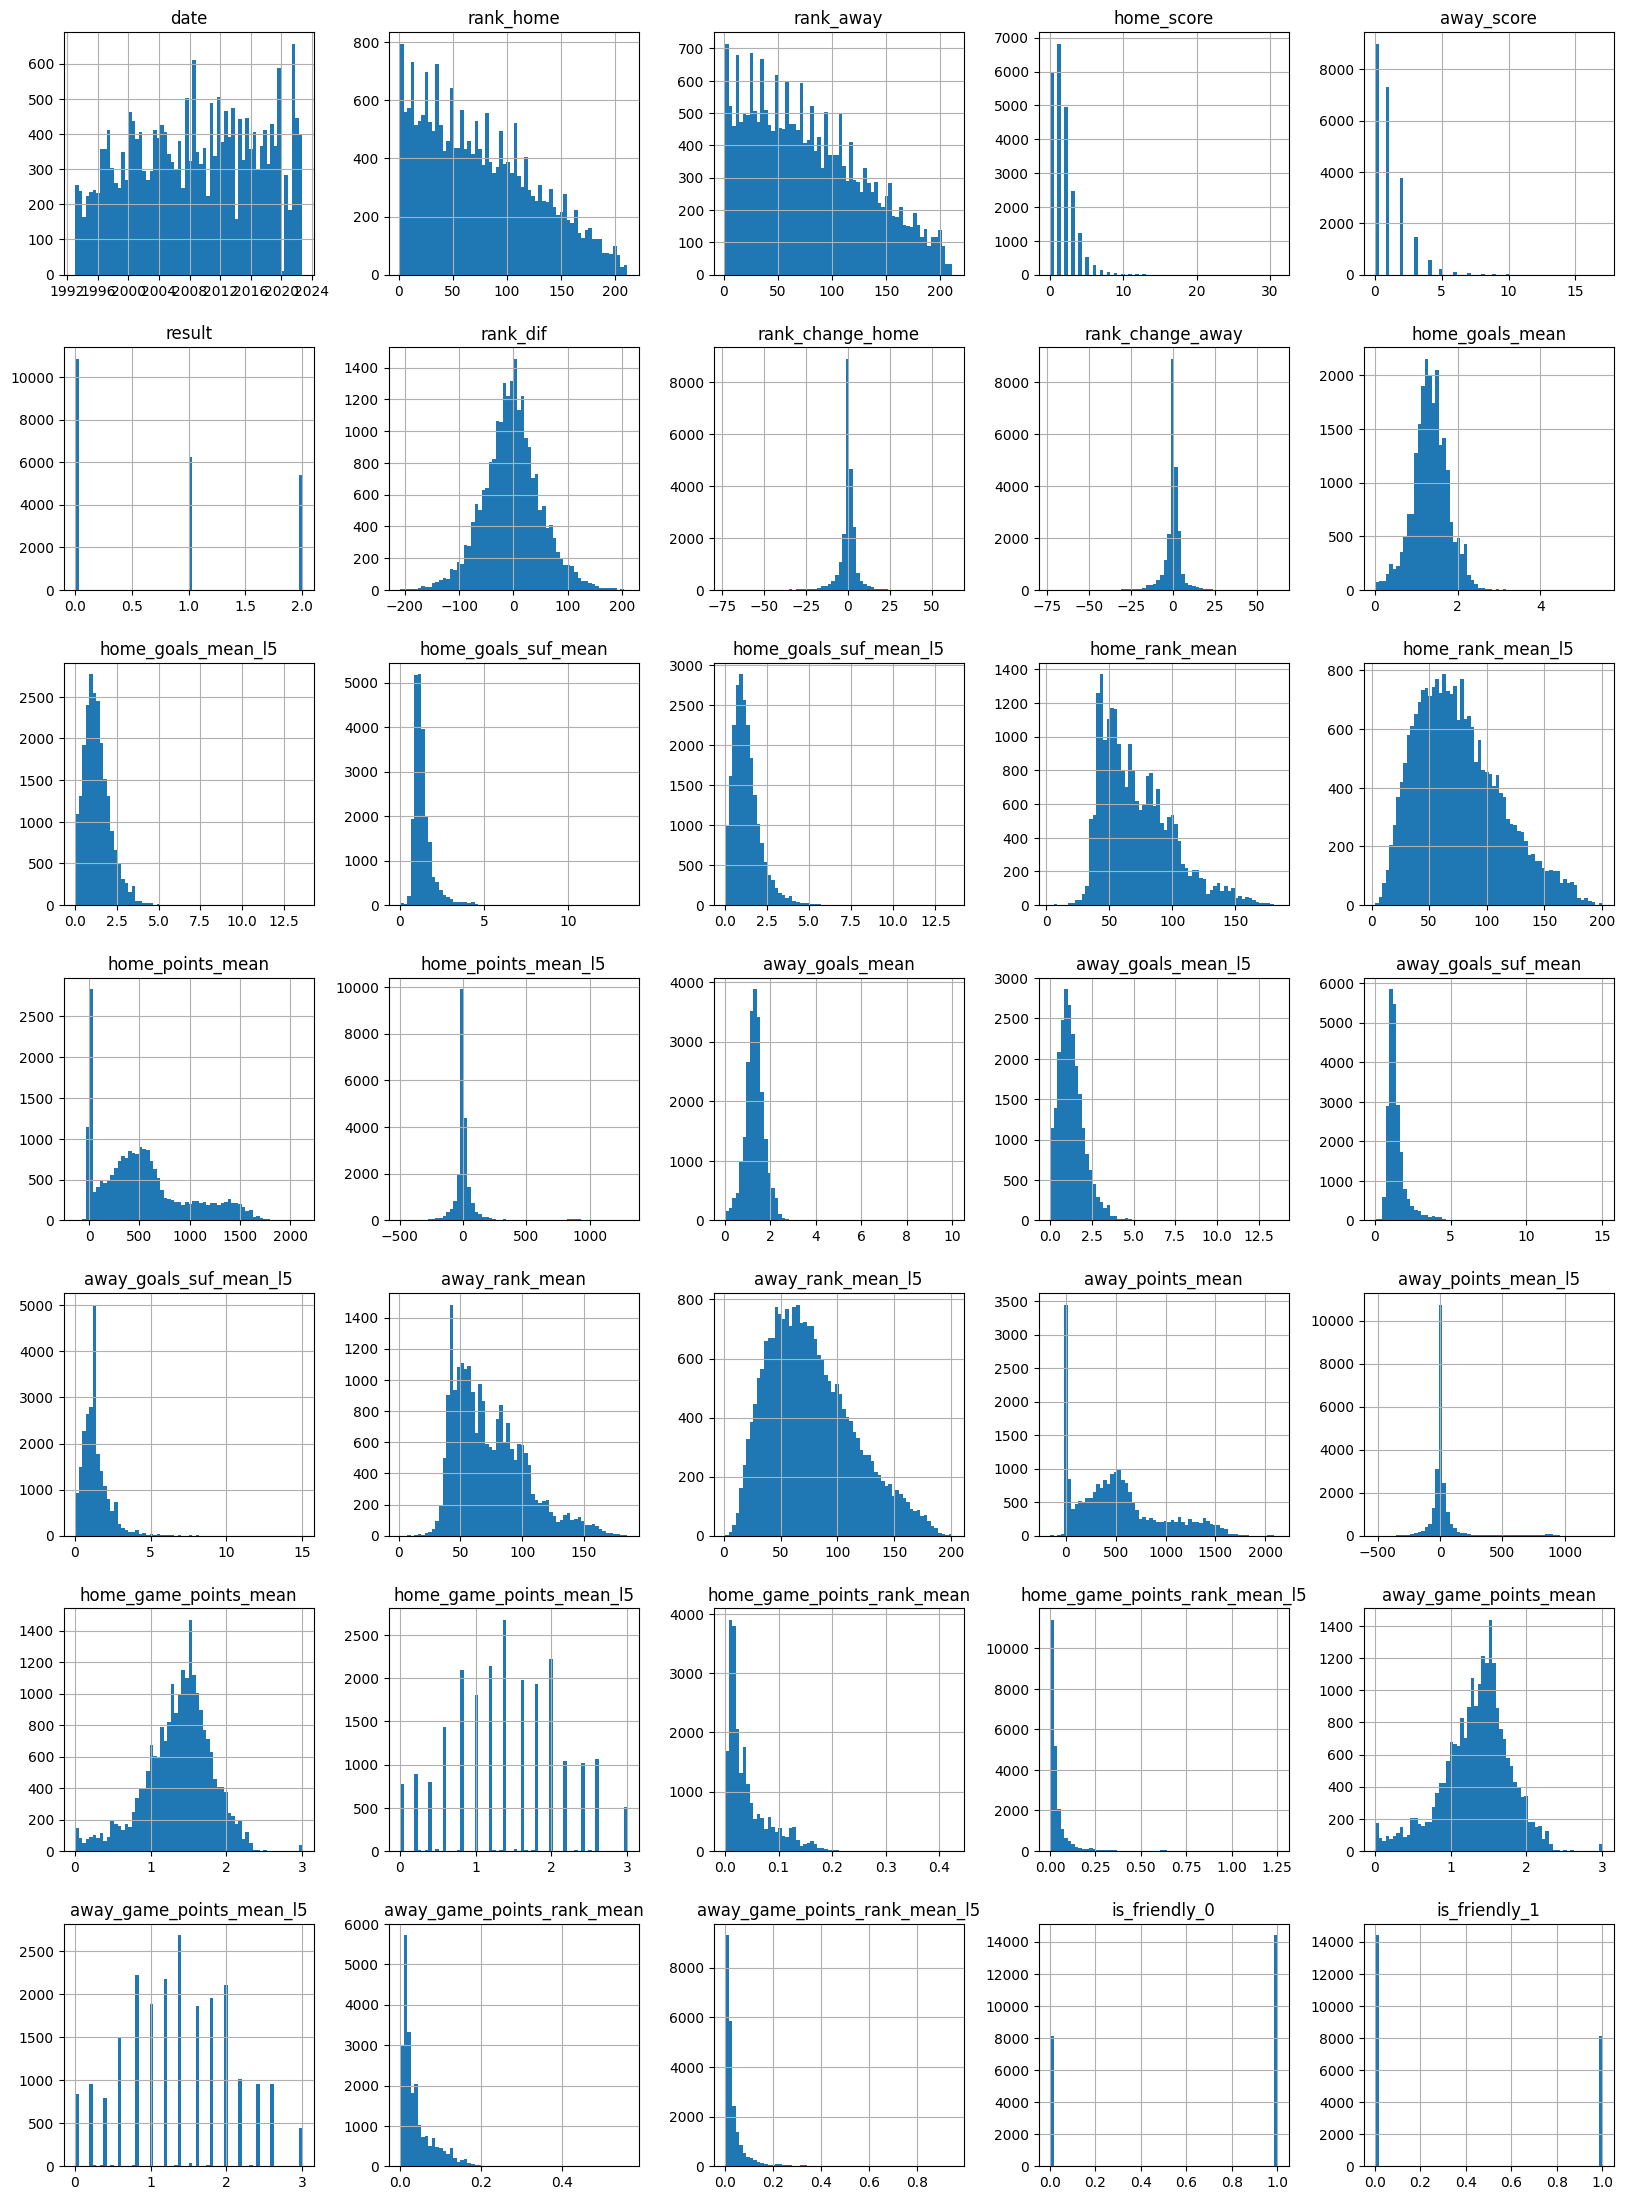

In [15]:
# Plotting the distributions
df.hist(bins=64, figsize=(20,40), layout=(10,5))
plt.show();

A partir das distribuições acima podemos notar que:
1) A maioria dos torneios desse dataset são do tipo não "Friendly", ou seja, que possuem impacto direto no ranking.
2) Existem menos jogos registrados nos anos anteriores ao ano 1996
3) Na maioria dos jogos, o time da casa ganha, mas a quantidade de gols realizados em casa é somente um pouco maior que a quantidade de gols fora de casa

### 4. Analisar correlações
- Target igual a 1 significa vitória da partida
- Target igual a 0 significa derrota da partida

In [16]:
# Definindo empates como uma vitória para o time que não é da casa
def no_draw(x):
    if x == 2:
        return 1
    else:
        return x
    
df["target"] = df["result"].apply(lambda x: no_draw(x))

/opt/conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
data1 = df[list(df.columns[8:20].values) + ["target"]]
data2 = df[df.columns[20:]]

scaled = (data1[:-1] - data1[:-1].mean()) / data1[:-1].std()
scaled["target"] = data1["target"]
violin1 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

scaled = (data2[:-1] - data2[:-1].mean()) / data2[:-1].std()
scaled["target"] = data2["target"]
violin2 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

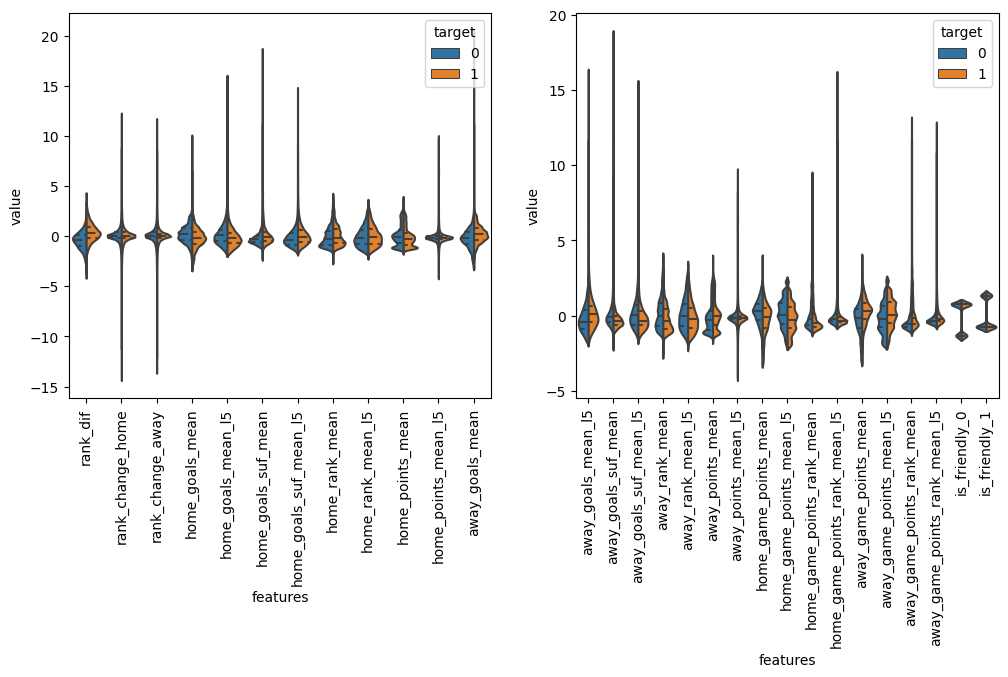

In [18]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

g1 = sns.violinplot(ax=axes[0], x="features", y="value", hue="target", data=violin1,split=True, inner="quart")
g1.set_xticklabels(axes[0].get_xticklabels(),rotation=90)

g2 = sns.violinplot(ax=axes[1], x="features", y="value", hue="target", data=violin2,split=True, inner="quart")
g2.set_xticklabels(axes[1].get_xticklabels(),rotation=90)

plt.show()

Notamos pela visualização acima que a única que faz uma separação entre uma vitória e uma derrota e a coluna abaixo:
- Diferença por ranking

In [19]:
dif = df.copy()
dif.loc[:, "goals_dif"] = dif["home_goals_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_mean_l5"]
dif.loc[:, "goals_suf_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_suf_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_made_suf_dif"] = dif["home_goals_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_made_suf_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_suf_made_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_suf_made_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_mean_l5"]

data_difs = dif.iloc[:, -8:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

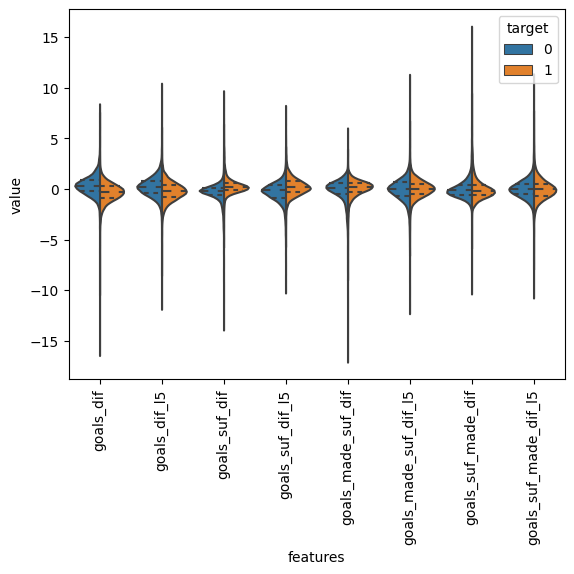

In [20]:
g3 = sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
g3.set_xticklabels(g3.get_xticklabels(),rotation=90)

plt.show()

Com essas mudanças, pode-se considerar que as colunas abaixo são relevantes para a predição também:
- Diferença de gols
- Diferença de gols nos últimos 5 jogos
- Quantidade de gols sofridos
- Quantidade de gols sofridos nos últimos 5 jogos

In [21]:
dif.loc[:, "dif_points"] = dif["home_game_points_mean"] - dif["away_game_points_mean"]
dif.loc[:, "dif_points_l5"] = dif["home_game_points_mean_l5"] - dif["away_game_points_mean_l5"]
dif.loc[:, "dif_points_rank"] = dif["home_game_points_rank_mean"] - dif["away_game_points_rank_mean"]
dif.loc[:, "dif_points_rank_l5"] = dif["home_game_points_rank_mean_l5"] - dif["away_game_points_rank_mean_l5"]
dif.loc[:, "dif_rank_agst"] = dif["home_rank_mean"] - dif["away_rank_mean"]
dif.loc[:, "dif_rank_agst_l5"] = dif["home_rank_mean_l5"] - dif["away_rank_mean_l5"]

dif.loc[:, "goals_per_ranking_dif"] = (dif["home_goals_mean"] / dif["home_rank_mean"]) - (dif["away_goals_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif"] = (dif["home_goals_suf_mean"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_dif_l5"] = (dif["home_goals_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_mean_l5"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif_l5"] = (dif["home_goals_suf_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean_l5"] / dif["away_rank_mean"])

In [22]:
data_difs = dif.iloc[:, -10:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

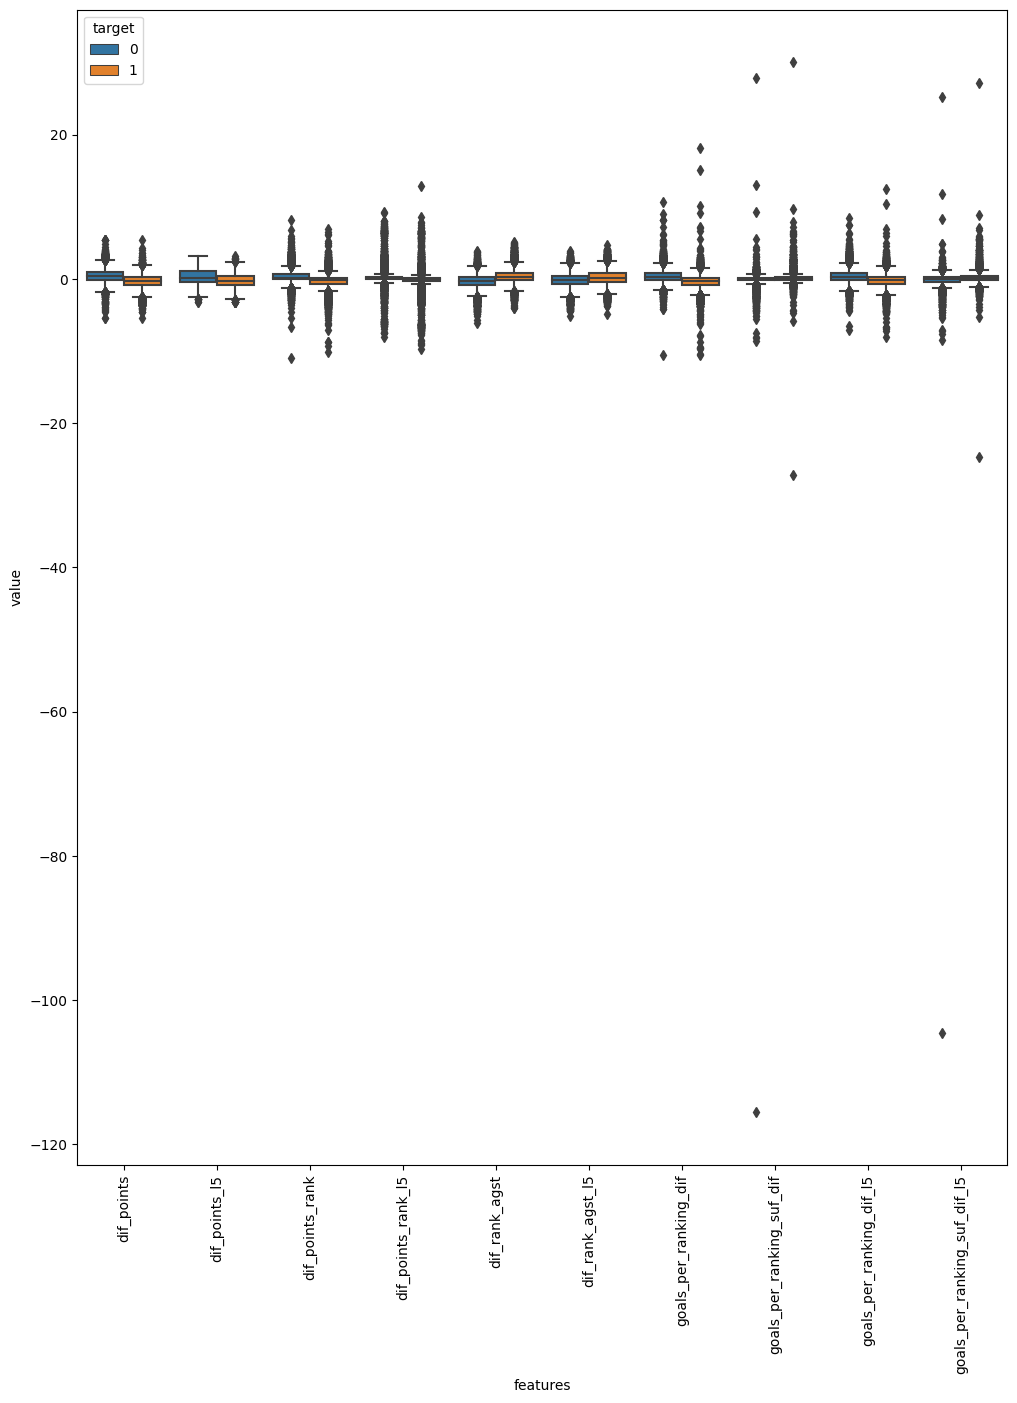

In [23]:
plt.figure(figsize=(12,15))
sns.boxplot(x="features", y="value", hue="target", data=violin)
plt.xticks(rotation=90)
plt.show()

A partir da visualização acima, acrescentaremos mais algumas colunas na nossa análise:
- Diferença de pontos
- Diferença de pontos nos últimos 5 jogos
- Diferença de pontos por ranking
- Diferença de pontos por ranking nos últimos 5 jogos
- Diferença de pontos por ranking
- Diferença de pontos por ranking nos últimos 5 jogos

<!-- Difference of points (full and last 5 games), difference of points by ranking faced (full and last 5 games) and difference of rank faced (full and last 5 games) are good features. Also, some of the generated features have very similar distributions which will be analyzed using scatterplots. -->

## 3. Analisar correlações
Verificaremos agora as distribuições das colunas que envolvem uma média dos últimos 5 jogos e compará-las com as distribuições que envolvem a média geral para avaliar se valerá a pena manter as duas ou não.

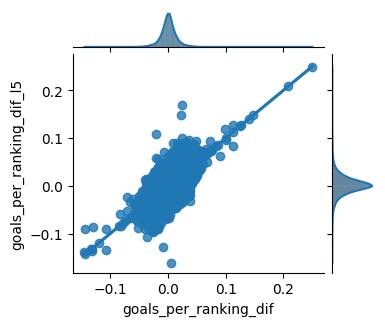

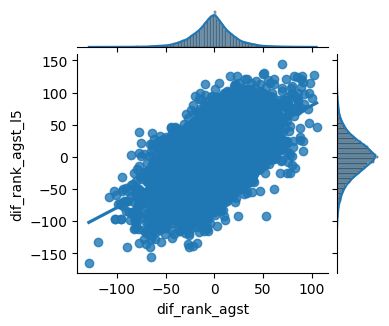

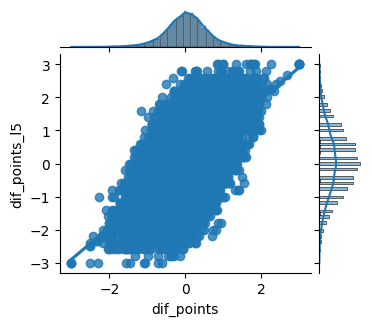

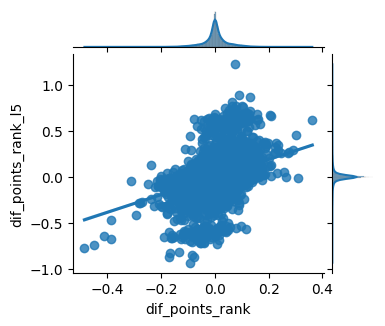

In [24]:
g1 = sns.jointplot(data=data_difs, x='goals_per_ranking_dif', y='goals_per_ranking_dif_l5', kind="reg")
g2 = sns.jointplot(data=data_difs, x='dif_rank_agst', y='dif_rank_agst_l5', kind="reg")
g3 = sns.jointplot(data=data_difs, x='dif_points', y='dif_points_l5', kind="reg")
g4 = sns.jointplot(data=data_difs, x='dif_points_rank', y='dif_points_rank_l5', kind="reg")

g1.fig.set_size_inches((3.5, 3))
g2.fig.set_size_inches((3.5, 3))
g3.fig.set_size_inches((3.5, 3))
g4.fig.set_size_inches((3.5, 3))

plt.show()

Como as distribuições da primeira visualização é muito parecida, iremos manter apenas uma das colunas.

Por fim, decidimos prosseguir com as seguintes colunas para a criação do modelo:

- Diferença de ranking
- Diferença de gols
- Diferença de gols nos últimos 5 jogos
- Diferença de gols sofridos
- Diferença de gols sofridos nos últimos 5 jogos
- Diferença média de ranking nos últimos 5 jogos
- Diferença média de ranking
- Número de gols por diferença de ranking
- Diferença de pontos no ranking
- Diferença de pontos no ranking nos últimos 5 jogos
- Se a competição é "Friendly" ou não (ou seja, se ela vale no ranking)